# Importing Libraries

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from scipy.spatial.distance import hamming, cosine

%matplotlib inline
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


# Dataset utils and preprocessing

In [2]:
def image_loader(path, size):
    # String path to image
    # Tuple size of output image
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, size, cv.INTER_CUBIC)

    return image

In [3]:
def dataset_preprocessing(dataset_path, labels_file_path, size, image_paths_pickle):
    # String path to dataset
    # String path to labels file
    # Tuple size of image
    # String name of pickle file where image paths are stored
    with open(labels_file_path, 'r') as f:
        classes = f.read().split('\n')[:-1]
    
    images = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(dataset_path):
        try:
            image_path = os.path.join(dataset_path, image_name)
            images.append(image_loader(image_path, size))
            image_paths.append(image_path)
            for idx in range(len(classes)):
                if classes[idx] in image_name:
                    labels.append(idx)
        except:
            pass
    
    with open("pickle_saves/" + image_paths_pickle + ".pickle", 'wb') as f:
        pickle.dump(image_paths, f)
    
    assert len(images) == len(labels)
    return np.array(images), np.array(labels)

# Utils functions

## 1. Cosine similarity

In [4]:
def cosine_distance(training_set_vectors, query_vector, top_n=30):
    
    distances = []
    # comparing each image to all training set
    for i in range(len(training_set_vectors)):
        distances.append(cosine(training_set_vectors[i], query_vector[0]))
    # return sorted indices of 30 most similar images
    return np.argsort(distances)[:top_n]

## 2. Hamming distance

In [5]:
def hamming_distance(training_set_vectors, query_vector, top_n=50):

    distances = []
    # comparing each image to all training set
    for i in range(len(training_set_vectors)):
        distances.append(hamming(training_set_vectors[i], query_vector[0]))
    # return sorted indices of 30 most similar images   
    return np.argsort(distances)[:top_n]

## 3. Sparse accuracy

In [6]:
def sparse_accuracy(true_labels, predicted_labels):

    # np array real labels of each sample
    # np matrix softmax probabilities
    
    assert len(true_labels) == len(predicted_labels)
    
    correct = 0
    for i in range(len(true_labels)):
        if np.argmax(predicted_labels[i]) == true_labels[i]:
            correct += 1
            
    return correct / len(true_labels)

# Utils Model functions

In [7]:
def model_inputs(size):
    # tuple of (height, width) of an image
    # shape = [batch_size, size[0], size[1], 3]  we set batch_size to None so it accepts any number
    # defining CNN inputs as placeholders
    inputs = tf.placeholder(dtype=tf.float32, shape=[None, size[0], size[1], 3], name='images')
    targets = tf.placeholder(dtype=tf.int32, shape=[None,], name='targets') # array of true labels
    dropout_prob = tf.placeholder(dtype=tf.float32, name='dropout_probs')
    
    return inputs, targets, dropout_prob

In [8]:
def conv_block(inputs,                  # data from a previous layer
               number_of_filters,       # integer, number of conv filters
               kernel_size,             # tuple, size of conv layer kernel
               strides=(1, 1),          
               padding='SAME',          # string, type of padding technique: SAME or VALID
               activation=tf.nn.relu,   # tf.object, activation function used on the layer
               max_pool=True,           # boolean, if true the conv block will use max_pool
               batch_norm=True):        # boolean, if true the conv block will use batch normalization
    
    conv_features = layer = tf.layers.conv2d(inputs=inputs, 
                                             filters=number_of_filters, 
                                             kernel_size=kernel_size, 
                                             strides=strides, 
                                             padding=padding, 
                                             activation=activation)
    
    if max_pool:
        layer = tf.layers.max_pooling2d(layer, 
                                        pool_size=(2, 2), 
                                        strides=(2, 2),
                                        padding='SAME')
        
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, conv_features

In [9]:
def dense_block(inputs,                 # data from a previous layer
                units,                  # integer, number of neurons/units for a dense layer
                activation=tf.nn.relu,  # tf.object, activation function used on the layer
                dropout_rate=None,      # dropout rate used in this dense block
                batch_norm=True):       # boolean, if true the conv block will use batch normalization
    
    dense_features = layer = tf.layers.dense(inputs, 
                                             units=units, 
                                             activation=activation)
    
    if dropout_rate is not None:
        layer = tf.layers.dropout(layer, rate=dropout_rate)
    
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, dense_features

In [10]:
def opt_loss(logits,            # pre-activated model outputs
             targets,           # true labels for each input sample
             learning_rate):
    # sparse means that we don't have to convert our targets to one hot encoding version
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    # Adam optimizer performs best on CNNs
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return loss, optimizer

In [11]:
# Refer to README.md to see the complete summary of the model when following along this cell of code
class ImageSearchModel(object):
    
    def __init__(self, 
                 learning_rate, 
                 size,                  # tuple of (height, width) of an image
                 number_of_classes=10): # integer number of classes in a dataset
        
        tf.reset_default_graph() # escape possibility of having nested models graphs
        
        # model inputs
        self.inputs, self.targets, self.dropout_rate = model_inputs(size)
        # every image is 0 to 255, so we add batch norm layer
        normalized_images = tf.layers.batch_normalization(self.inputs)
        
        # conv_1 block
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images, 
                                                        number_of_filters=64, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        # conv_2 block
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1, 
                                                        number_of_filters=128, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        # conv_3 block
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2, 
                                                        number_of_filters=256, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        # conv_4 block
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3, 
                                                        number_of_filters=512, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        # flattening the last conv lock to one single vector flat_layer
        flat_layer = tf.layers.flatten(conv_block_4)

        # dense_1 block
        dense_block_1, dense_1_features = dense_block(inputs=flat_layer, 
                                                       units=128, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        # dense_2 block
        dense_block_2, self.dense_2_features = dense_block(inputs=dense_block_1, 
                                                       units=256, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True) 
        # dense_3 block
        dense_block_3, self.dense_3_features = dense_block(inputs=dense_block_2, 
                                                       units=512, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        # dense_4 block
        dense_block_4, self.dense_4_features = dense_block(inputs=dense_block_3, 
                                                       units=1024, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)  
        # output layer
        logits = tf.layers.dense(inputs=dense_block_4, 
                                 units=number_of_classes, 
                                 activation=None)
        
        self.predictions = tf.nn.softmax(logits)  # turn logits into a probs vector perdictions
        
        self.loss, self.optimizer = opt_loss(logits=logits, 
                                             targets=self.targets, 
                                             learning_rate=learning_rate)

In [12]:

def train(model, 
          epochs,
          drop_rate,
          batch_size, 
          data, 
          save_dir, 
          saver_delta=0.15):
    
    x_train, y_train, x_test, y_test = data
    
    # start session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    # define saver
    saver = tf.train.Saver()
    
    best_test_accuracy = 0.0
    # start training loop
    for epoch in range(epochs):
        
        train_accuracy = []
        train_loss = []
        
        for j in range(len(x_train) // batch_size):
            start_id = j * batch_size
            end_id = start_id + batch_size
            
            x_batch = x_train[start_id : end_id]
            y_batch = y_train[start_id : end_id]
            
            feed_dict = {model.inputs : x_batch, 
                         model.targets : y_batch, 
                         model.dropout_rate : drop_rate}
            
            _, t_loss, preds_tr = session.run([model.optimizer, model.loss, model.predictions], feed_dict=feed_dict)
            
            train_accuracy.append(sparse_accuracy(y_batch, preds_tr))
            train_loss.append(t_loss)
            
        print("Epoch: {}/{}".format(epoch, epochs),  
              " | Training accuracy: {}".format(np.mean(train_accuracy)), 
              " | Training loss: {}".format(np.mean(train_loss)) )
        
        test_accuracy = []
        
        for j in range(len(x_test) // batch_size):
            start_id = j * batch_size
            end_id = start_id + batch_size
            
            x_batch = x_test[start_id : end_id]
            y_batch = y_test[start_id : end_id]
            
            feed_dict = {model.inputs : x_batch, 
                         model.dropout_rate : 0.0}
            
            preds_test = session.run(model.predictions, feed_dict=feed_dict)
            test_accuracy.append(sparse_accuracy(y_batch, preds_test))
            
        print("Test accuracy: {}".format(np.mean(test_accuracy)))
        
        # saving the model
        if np.mean(train_accuracy) > np.mean(test_accuracy): # to prevent underfitting
            if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <= saver_delta: # to prevent overfitting
                if np.mean(test_accuracy) >= best_test_accuracy:
                    best_test_accuracy = np.mean(test_accuracy)
                    saver.save(session, "{}/model_epoch_{}.ckpt".format(save_dir, epoch))
                    
    session.close()

# Hyperparameters

In [24]:
epochs = 10
batch_size = 128
learning_rate = 0.001
dropout_probs = 0.6
image_size = (32, 32)

# Loading Data

In [15]:
x_test, y_test = dataset_preprocessing('dataset/test/', 'dataset/labels.txt', size=image_size, image_paths_pickle="test_images_pickle")
print(x_test.shape, y_test.shape)

(10000, 32, 32, 3) (10000,)


In [16]:
x_train, y_train = dataset_preprocessing('dataset/train/', 'dataset/labels.txt', size=image_size, image_paths_pickle="train_images_pickle")
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000,)


In [25]:
model = ImageSearchModel(learning_rate, image_size)

In [26]:
data = (x_train, y_train, x_test, y_test)

# Training the model

In [27]:
train(model, epochs, dropout_probs, batch_size, data, 'checkpoints')

Epoch: 0/10  | Training accuracy: 0.3785857371794872  | Training loss: 1.819966197013855
Test accuracy: 0.5044070512820513
Epoch: 1/10  | Training accuracy: 0.5532852564102564  | Training loss: 1.228572130203247
Test accuracy: 0.5944511217948718
Epoch: 2/10  | Training accuracy: 0.6357371794871794  | Training loss: 1.0232571363449097
Test accuracy: 0.6326121794871795
Epoch: 3/10  | Training accuracy: 0.6854967948717948  | Training loss: 0.893772542476654
Test accuracy: 0.6642628205128205
Epoch: 4/10  | Training accuracy: 0.7172876602564102  | Training loss: 0.8081424236297607
Test accuracy: 0.6587540064102564
Epoch: 5/10  | Training accuracy: 0.7417668269230769  | Training loss: 0.7334949374198914
Test accuracy: 0.6606570512820513
Epoch: 6/10  | Training accuracy: 0.7691105769230769  | Training loss: 0.6650800704956055
Test accuracy: 0.6558493589743589
Epoch: 7/10  | Training accuracy: 0.7961338141025641  | Training loss: 0.5928162336349487
Test accuracy: 0.6528445512820513
Epoch: 8/10

In [29]:
def create_training_set_vectors(model, 
                                x_train, 
                                y_train,
                                batch_size,
                                checkpoint_path,     # string path to the model checkpoint
                                image_size, 
                                distance='hamming'):
    # Define session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    # Restore session
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []

    #iterate through training set
    for j in range(len(x_train) // batch_size):
        start_id = j * batch_size
        end_id = start_id + batch_size

        x_batch = x_train[start_id : end_id]

        feed_dict = {model.inputs : x_batch, 
                     model.dropout_rate : 0.0}
        
        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    # hamming distance - vectors processing
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1) # binarize vectors
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        with open('pickle_saves/hamming_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    # cosine distance - vectors processing
    elif distance == 'cosine':
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
        with open('pickle_saves/cosine_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)

In [46]:
def create_training_set_vectors_with_colors(model, 
                                            x_train, 
                                            y_train,
                                            batch_size,
                                            checkpoint_path, 
                                            image_size, 
                                            distance='hamming'):            
    # Define session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    # Restore session
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []
    
    ##########################################################################
    ### Calculate color feature vectors for each image in the training set ###
    color_features = []
    for img in x_train:
        channels = cv.split(img)
        features = []
        for chan in channels:
            hist = cv.calcHist([chan], [0], None, [256], [0, 256])
            features.append(hist)
            
        color_features.append(np.vstack(features).squeeze())
    ##########################################################################
    
    #iterate through training set
    for j in range(len(x_train) // batch_size):
        start_id = j * batch_size
        end_id = start_id + batch_size

        x_batch = x_train[start_id : end_id]

        feed_dict = {model.inputs : x_batch, 
                     model.dropout_rate : 0.0}
        
        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    #hamming distance - vectors processing
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1) #binarize vectors
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        with open('pickle_saves/hamming_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    #cosine distance - vectors processing
    elif distance == 'cosine':
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
        with open('pickle_saves/cosine_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    #########################################################################
    ### Save training set color feature vectors to a separate pickle file ###
    with open('pickle_saves/color_vectors.pickle', 'wb') as f:
        pickle.dump(color_features[:len(training_vectors)], f)
    #########################################################################

In [47]:
model = ImageSearchModel(learning_rate, image_size)

In [48]:
create_training_set_vectors_with_colors(model, x_train, y_train, batch_size, 'checkpoints/model_epoch_3.ckpt', image_size)

INFO:tensorflow:Restoring parameters from checkpoints/model_epoch_3.ckpt


In [61]:
from scipy.spatial.distance import euclidean
def compare_color(color_vectors,         # color features vectors of closest training set images to the uploaded image            
                  uploaded_image_colors, # color vector of the uploaded image
                  ids):                  # indices of training images being closest to the uploaded image (output from a distance function)    

    color_distances = []
    
    for i in range(len(color_vectors)):
        color_distances.append(euclidean(color_vectors[i], uploaded_image_colors))
        
    # The 15 is just an random number that I have choosen, you can return as many as you need/want
    return ids[np.argsort(color_distances)[:15]]

In [50]:
def simple_inference(model, 
                     session,
                     train_set_vectors, 
                     uploaded_image_path,   # string, path to the uploaded image
                     image_size, 
                     distance='hamming'):

    image = image_loader(uploaded_image_path, image_size)
    channels = cv.split(image)
    features = []
    
    for chan in channels:
        hist = cv.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
    elif distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
    return closest_ids

In [51]:
def simple_inference_with_color_filters(model, 
                                         session,
                                         train_set_vectors, 
                                         uploaded_image_path,
                                         color_vectors,
                                         image_size, 
                                         distance='hamming'):
    
    image = image_loader(uploaded_image_path, image_size)
    
    ####################################################
    ## Calculating color histogram of the query image ##
    channels = cv.split(image)
    features = []
    for chan in channels:
        hist = cv.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    ####################################################
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
        # Comparing color features between query image and closest images selected by the model
        closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    elif distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
        # Comparing color features between query image and closest images selected by the model
        closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    return closest_ids

# Pipeline Test

## Restore Session

In [52]:
model = ImageSearchModel(learning_rate, image_size)

session = tf.Session()
session.run(tf.global_variables_initializer())

In [53]:
saver = tf.train.Saver()
saver.restore(session, "checkpoints/model_epoch_3.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/model_epoch_3.ckpt


## Load image paths

In [54]:
with open('pickle_saves/train_images_pickle.pickle', 'rb') as f:
    train_image_paths = pickle.load(f)

In [55]:
train_image_paths[:10]

['dataset/train/0_frog.png',
 'dataset/train/10000_automobile.png',
 'dataset/train/10001_frog.png',
 'dataset/train/10002_frog.png',
 'dataset/train/10003_ship.png',
 'dataset/train/10004_ship.png',
 'dataset/train/10005_cat.png',
 'dataset/train/10006_deer.png',
 'dataset/train/10007_frog.png',
 'dataset/train/10008_airplane.png']

## Load trainig set vectors

In [56]:
with open('pickle_saves/hamming_train_vectors.pickle', 'rb') as f:
    train_set_vectors = pickle.load(f)

In [57]:
with open('pickle_saves/color_vectors.pickle', 'rb') as f:
    color_vectors = pickle.load(f)

In [64]:
test_image = 'dataset/train/10000_automobile.png'

In [65]:
result_ids = simple_inference_with_color_filters(model, session, train_set_vectors, test_image, color_vectors, image_size, distance='hamming')

# Show query image

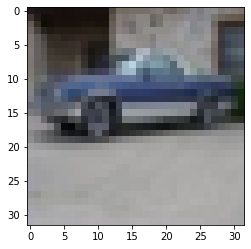

In [66]:
plt.imshow(image_loader(test_image, image_size))

# Show result images

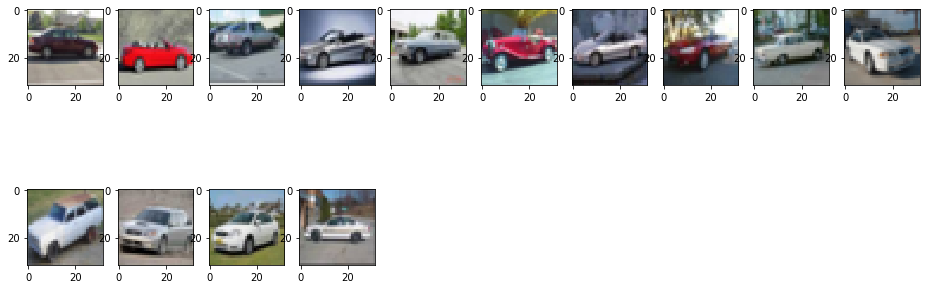

In [67]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
colums = 10
rows = 5
for i in range(1, colums*rows+1):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows, colums, i)
        plt.imshow(image)
    except:
        pass
plt.show()